# Analyse dynamique des déterminants des prix immobiliers et de l'impact des taux d'intérêt sur le marché du logement

**Projet Python - 2A ENSAE**

## Introduction

Notre projet vise à étudier l'influence des taux d'intérêt sur les prix immobilier au niveau local, en prenant en compte les caractéristiques spécifiques de chaque commune telles que la densité de population, le niveau de revenus, le chômage, le taux de criminalité... L'objectif principal est donc d'analyser les déterminants dynamiques des prix immobilier au niveau communal et d'étudier l'impact des taux d'intérêt sur le marché immobilier en utilisant des méthodes économétriques. Cela implique notamment l'exploration de données de séries temporelles et de panel pour fournir une compréhension complète.

Notre étude porte sur les années 2014 à 2023 pour prendre en compte au maximum les variations des taux d'intérêt. Pour réaliser notre étude, nous nous sommes notamment appuyés sur le jeu de données "Demandes de Valeurs Foncières" disponible sur data.gouv.fr (https://www.data.gouv.fr/en/datasets/demandes-de-valeurs-foncieres/) qui liste les transactions immobilières intervenues au cours des dernières années sur le territoire métropolitain et les DOM-TOM. 

Le projet se décompose en plusieurs étapes : 
1. Récupération des données

2. Agrégation

3. Visualisation de données

4. Création des variables de contrôle

5. Modélisation économétrique

## Les importations 

In [58]:
import pandas as pd
import numpy as np
import pyarrow.feather as feather
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import grangercausalitytests
from linearmodels import PanelOLS, RandomEffects
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.panel import compare
from statsmodels.tsa.stattools import adfuller

In [3]:
# Change path as needed
path = "C:/Users/lujul/OneDrive/Documents/Github/interestnpy"

## I. Récupération des données

### I.1. Création de la table de passage 

La géographie des communes en France a changé entre 2014 et 2023. Nous avons donc dû construire une table de passage pour prendre en compte ce problème.

In [4]:
#IMPORTS AND FILTER INSEE TRANSLATION TABLE
passage1423_df = pd.read_excel(path+"/data/external/GEOCOM/table_passage_annuelle_2023.xlsx", 
                               sheet_name="COM", skiprows=5)
passage1423_df = passage1423_df.filter(regex='^CODGEO').iloc[:, :10]
passage1423_df = passage1423_df[passage1423_df['CODGEO_2023'].notna()]

In [5]:
#IMPORTS 2023 EPCI DEFINITIONS
fcom_df = pd.read_excel(path+"/data/external/GEOCOM/ZE2020_au_01-01-2023.xlsx", 
                            sheet_name="Composition_communale", skiprows=5)

epc_com = pd.read_excel(path+"/data/external/GEOCOM/Intercommunalite_Metropole_au_01-01-2023.xlsx", 
                            sheet_name="Composition_communale", skiprows=5)

fcom_df = pd.merge(fcom_df, epc_com, how='left', on=['CODGEO','LIBGEO', 'DEP', 'REG'])

In [6]:
#CREATES COM BASED ON 2023 TOWN CODES AND ZE BASED ON EPCI
fcom_df['COM'] = fcom_df['CODGEO']
fcom_df['LIB_COM'] = fcom_df['LIBGEO']
fcom_df['ZE'] = fcom_df['ZE2020']
fcom_df['LIB_ZE'] = fcom_df['LIBZE2020']
fcom_df['EPCI'] = fcom_df['ZE2020']
fcom_df['LIB_ZE'] = fcom_df['LIBZE2020']
fcom_df['EPCI'] = fcom_df.apply(
    lambda row: row['CODGEO'] if any(x in row['LIBEPCI'] for x in ["Métropole du Grand Paris", "Métropole de Lyon", "Métropole d'Aix-Marseille-Provence"]) else row['EPCI'],
    axis=1
)
fcom_df['LIB_EPCI'] = fcom_df.apply(
    lambda row: row['LIBGEO'] if any(x in row['LIBEPCI'] for x in ["Métropole du Grand Paris", "Métropole de Lyon", "Métropole d'Aix-Marseille-Provence"]) else row['LIBEPCI'],
    axis=1
)
fcom_df['LIB_EPCI'] = fcom_df.apply(
    lambda row: "Iles-FR" if row['EPCI'] == "ZZZZZZZZZ" else row['LIB_EPCI'],
    axis=1
)
fcom_df.rename(columns={'CODGEO': 'CODGEO_2023'}, inplace=True)
fcom_df = fcom_df[['CODGEO_2023', 'COM', 'LIB_COM', 'ZE', 'LIB_ZE', 'EPCI', 'LIB_EPCI']]

In [7]:
#MERGES WITH INSEE TABLE TO CREATE THE TRANSLATION TABLE 
ident1423_df = pd.merge(passage1423_df, fcom_df, how='left', on='CODGEO_2023')

In [8]:
#FIXES PROBLEMS RELATED TO CITIES WITH "ARRONDISSEMENTS"
conditions_arr = [
    ident1423_df['CODGEO_2023'].str.startswith("75"),
    ident1423_df['CODGEO_2023'].str.startswith("132"),
    ident1423_df['CODGEO_2023'].str.startswith("6938")
]

ze_arr = [1109, 9312, 8421]
lib_arr = ["Paris", "Marseille", "Lyon"]

ident1423_df['COM'] = ident1423_df.apply(
    lambda row: row['CODGEO_2023'] if pd.isna(row['COM']) else row['COM'],
    axis=1
)

ident1423_df['EPCI'] = ident1423_df.apply(
    lambda row: row['CODGEO_2023'] if pd.isna(row['EPCI']) else row['EPCI'],
    axis=1
)
ident1423_df['EPCI'] = ident1423_df['EPCI'].astype(str)

ident1423_df['ZE'] = np.select(
  conditions_arr, 
  ze_arr, 
  default=ident1423_df['ZE'])

In [9]:
def create_lib_ident(row, col_name):
    if pd.isna(row[col_name]):
        if row['COM'][:2] == "75":
            return f"Paris {row['COM'][3:5]}"
        elif row['COM'][:2] == "69":
            return f"Lyon {int(row['CODGEO_2019']) - 80}"
        elif row['COM'][:2] == "13":
            return f"Marseille {row['COM'][3:5]}"
    else:
        return row[col_name]

In [10]:
ident1423_df['LIB_COM'] = ident1423_df.apply(create_lib_ident, col_name='LIB_COM', axis=1)

ident1423_df['LIB_EPCI'] = ident1423_df.apply(
    lambda row: row['LIB_COM'] if pd.isna(row['LIB_EPCI']) else row['LIB_EPCI'],
    axis=1
) 

ident1423_df['LIB_ZE'] = np.select(
  conditions_arr, 
  lib_arr, 
  default=ident1423_df['LIB_ZE'])

In [11]:
#REORDERS AND EXPORTS THE TRANSLATION TABLE
reord_cols = ['COM', 'ZE', 'LIB_COM', 'LIB_ZE', 'EPCI', 'LIB_EPCI']
ident1423_df = ident1423_df[reord_cols + [col for col in ident1423_df.columns if col not in reord_cols]]
ident1423_df.to_feather(path+"/data/interim/tble_de_passage_py.feather")

In [12]:
ident1423_df.head()

,COM,ZE,LIB_COM,LIB_ZE,EPCI,LIB_EPCI,CODGEO_2023,CODGEO_2022,CODGEO_2021,CODGEO_2020,CODGEO_2019,CODGEO_2018,CODGEO_2017,CODGEO_2016,CODGEO_2015,CODGEO_2014
0,13201,9312.0,Marseille 01,Marseille,13201,Marseille 01,13201,13201,13201,13201,13201,13201,13201,13201,13201,13201
1,13202,9312.0,Marseille 02,Marseille,13202,Marseille 02,13202,13202,13202,13202,13202,13202,13202,13202,13202,13202
2,13203,9312.0,Marseille 03,Marseille,13203,Marseille 03,13203,13203,13203,13203,13203,13203,13203,13203,13203,13203
3,13204,9312.0,Marseille 04,Marseille,13204,Marseille 04,13204,13204,13204,13204,13204,13204,13204,13204,13204,13204
4,13205,9312.0,Marseille 05,Marseille,13205,Marseille 05,13205,13205,13205,13205,13205,13205,13205,13205,13205,13205


### I.2. Prix des terrains par département

Nous utilisons des données du Ministère de la Transition écologique sur les prix des terrains par région de 2008 à 2022 afin de soustraire les prix des terrains des montants des transactions dans les données DVF.

In [13]:
#LOADS CONVERSION TABLE REG - DEP
depreg_df = pd.read_excel(path+"/data/external/GEOCOM/table-appartenance-geo-communes-19.xls", 
                          sheet_name="COM", skiprows=5)[['DEP', 'REG']].drop_duplicates()
depreg_df['REG'] = depreg_df['REG'].astype(str)

#LOADS REGIONAL PRICES FOR LAND
ter_df = pd.read_csv(path+"/data/external/TER/1-Terrains-achetes-nombre-surface-et-prix-moyen-par-region.2022-01.csv", 
                     delimiter=";", skiprows=1, escapechar='\\', skipinitialspace=True)

In [14]:
#CREATING ADDITIONAL CONSTANT VALUES FOR 2023
additional_rows_2023 = ter_df[ter_df['ANNEE'] == 2022].copy()
additional_rows_2023['ANNEE'] = 2023
ter_df = pd.concat([ter_df, additional_rows_2023]).sort_values('ANNEE')
ter_df = ter_df[ter_df['ANNEE'] > 2013]

In [15]:
#MERGES TO GO FROM REGIONAL LEVEL TO DEPARTMENT LEVEL AND EXPORTS
terdep_df = pd.merge(depreg_df, ter_df, left_on='REG', right_on='ZONE_CODE', how='left')
terdep_df = terdep_df.dropna().reset_index(drop=True)[['ANNEE', 'DEP', 'PTM2_MED']]
terdep_df.to_feather(path+"/data/interim/terrains_py.feather")

In [16]:
terdep_df.head()

,ANNEE,DEP,PTM2_MED
0,2014.0,01,105.0
1,2015.0,01,100.0
2,2016.0,01,100.0
3,2017.0,01,103.0
4,2018.0,01,106.0


### I.3. Inflation - Taux d'intérêt

In [17]:
#INFLATION TABLE
inflation = pd.read_excel(path+"/data/external/INFLATION/econ-gen-taux-inflation.xlsx", 
                          sheet_name="Données", skiprows=3, nrows=9)
inflation.rename(columns={"Année": "AN", "Taux d'inflation": "INFLATION"}, inplace=True)
inflation['AN'] = inflation['AN'].astype(str)
inflation = inflation._append({'AN': str(2023), 'INFLATION': 2.3}, ignore_index=True)
#Why 2.3? first 3 months inflation
#either way it does not matter as we will work in basis 2023
inflation.sort_values(by="AN", inplace=True)
inflation['Date'] = inflation['AN']+"0101"
inflation.loc[len(inflation)] = ["2023",0, "20230401"]
inflation['TOT'] = (1 + inflation['INFLATION'].shift(1) / 100).cumprod()
inflation['TOT'] = inflation['TOT'].fillna(1)

In [18]:
# INTEREST RATES TABLE
interest_rates = pd.read_excel(path+"/data/external/INFLATION/series_panorama_202309.xlsx", 
                               sheet_name="G3", 
                               skiprows=6, 
                               names=["Date", "ir", "ir10_avg", "ir20_avg"])

interest_rates = interest_rates[interest_rates['Date'] > '2013-12-31']

interest_rates['quarter'] = interest_rates['Date'].dt.to_period('Q').astype(str)
interest_rates = interest_rates.groupby('quarter').agg({'ir': 'mean'}).reset_index()

In [19]:
def get_month_from_quarter(quarter):
    quarter_num = quarter.split("Q")[1]
    return {'1': '01', '2': '04', '3': '07', '4': '10'}.get(quarter_num, None)

In [20]:
interest_rates['themonth'] = interest_rates['quarter'].apply(get_month_from_quarter)
interest_rates['Date'] = (interest_rates['quarter'].str[:4] + interest_rates['themonth'] + "01")
interest_rates = interest_rates[['Date', 'ir']]

In [21]:
# Combine inflation and interest rates
irflation = pd.merge(interest_rates, inflation, on='Date', how='left')
irflation = irflation.interpolate(method="slinear", fill_value="extrapolate", limit_direction="both")
irflation['BASE14'] = irflation['TOT'] / irflation['TOT'].iloc[0]
irflation['BASE23'] = irflation['BASE14'] / irflation['BASE14'].iloc[37]
irflation.to_feather(path+"/data/interim/irflation.feather")

In [22]:
irflation.head()

,Date,ir,AN,INFLATION,TOT,BASE14,BASE23
0,20140101,3.183333,2014,0.500,1.00000,1.00000,0.869350
1,20140401,3.083333,NaN,0.375,1.00125,1.00125,0.870437
2,20140701,2.883333,NaN,0.250,1.00250,1.00250,0.871524
3,20141001,2.683333,NaN,0.125,1.00375,1.00375,0.872610
4,20150101,2.506667,2015,0.000,1.00500,1.00500,0.873697


# II. Agrégation

Dans cette partie, on agrège les données DVF trimestriellement en utilisant une fonction personnalisée à 3 niveaux distincts : commune, EPCI et zone d'emploi. Les données ont été filtrées et à chaque niveau d'agrégation, 3 variables d'intérêt ont été gardées : le nombre de transactions, le prix médian et la part des maisons dans le total des transactions. Cette proportion est utilisée comme variable de contrôle pour les différences structurelles du marché de l'immobilier des différentes communes car les maisons sont souvent moins chères au mètre carré que les appartements.

In [32]:
terdep_df = pd.read_feather(path+"/data/interim/terrains_py.feather")
ident_df = pd.read_feather(path+"/data/interim/tble_de_passage_py.feather").drop_duplicates()

In [ ]:
def aggreg_fun(data, ID, LIB_ID):
    quantiles = data.groupby([ID, LIB_ID, 'Date', 'Type local'])['prixM2'].quantile([0.05, 0.95]).unstack()
    quantiles.columns = ['quantile_05', 'quantile_95']
    data = data.merge(quantiles, left_on=[ID, LIB_ID, 'Date', 'Type local'], right_index=True)
    filtered_data = data[(data['prixM2'] <= data['quantile_95']) & (data['prixM2'] >= data['quantile_05'])]
    print("filtered!")
    data_agreg = filtered_data.groupby([ID, LIB_ID,'Date']).agg(
     n_transactions=('prixM2', 'size'),
     prop_maison=('Type local', lambda x: np.mean(x == 'Maison')),
    prixM2=('prixM2', 'median')
    ).reset_index()
    return data_agreg

In [ ]:
def immo_prices(year):
    # Read data
    df = pd.read_csv(path+f"/data/external/DFV/valeursfoncieres-{year}.txt", delimiter="|", dtype=str)
    df = df.dropna(axis=1, how='all')  
    # Filter and mutate
    df = df[df['Nature mutation'] == "Vente"]
    df = df[df['Code type local'].isin(['1', '2'])]
    df = df[~df['Code departement'].isin(['971', '972', '973', '974'])]
    df['Code commune'] = df['Code commune'].str.pad(width=3, side='left', fillchar='0')
    df['depcom'] = df['Code departement'] + df['Code commune']
    df['Valeur fonciere'] = df['Valeur fonciere'].str.replace(",", ".").astype(float)
    print("ok-1")
    # Quarter and date manipulation
    df['quarter_num'] = df['Date mutation'].str[3:5].astype(int)
    df['qmonth'] = np.select([df['quarter_num'].isin(range(1, 4)), df['quarter_num'].isin(range(4, 7)), df['quarter_num'].isin(range(7, 10)), df['quarter_num'].isin(range(10, 13))], ["01", "04", "07", "10"], default=np.nan)
    df['Date'] = (str(year) + df['qmonth'] + "01")
    print("ok-2")
    # Merging with ident_year_df
    ident_year_df = ident_df[['COM', 'EPCI', 'ZE', 'LIB_COM', 'LIB_EPCI', 'LIB_ZE', f'CODGEO_{year}']].drop_duplicates()
    df = df.merge(ident_year_df, left_on='depcom', right_on=f'CODGEO_{year}', how='left')
    print("ok-3")
    # Merging with terdep_df
    df = df.merge(terdep_df[terdep_df['ANNEE'] == int(year)], left_on='Code departement', right_on='DEP', how='left')
    print("ok-4")
    # Calculating prixM2
    df['Surface terrain'] = df['Surface terrain'].replace(np.nan, 0).astype(float)
    df['prixM2'] = (df['Valeur fonciere'] - df['Surface terrain'] * df['PTM2_MED']) / df['Surface reelle bati'].astype(float)
    df = df[(df['prixM2'] > 10) & (df['prixM2'] < 100000)].drop_duplicates()
    print("ok-5")
    df = df.drop_duplicates(subset=['Date mutation', 'No voie', 'Valeur fonciere', 'Surface terrain', 'LIB_COM'])
    df4_epci = aggreg_fun(df,"EPCI","LIB_EPCI")
    print("ok-6")
    df4_com = aggreg_fun(df,"COM", "LIB_COM")
    print("ok-7")
    df4_ze = aggreg_fun(df,"ZE","LIB_ZE")
    print("ok-8")
    df4_full = df.groupby('Date', as_index=False).agg(prixM2=('prixM2', 'mean'))


    return [df4_com, df4_epci, df4_ze, df4_full]

In [ ]:
years = ["2023", "2022", "2021", "2020", "2019", "2018", "2017", "2016", "2015", "2014"]
results = []

for i in years:
  results.append(immo_prices(i))

In [ ]:
# Merging results
immo1423_com = pd.concat([result[0] for result in results])
immo1423_epci = pd.concat([result[1] for result in results])
immo1423_ze = pd.concat([result[2] for result in results])
immo1423_full = pd.concat([result[3] for result in results])

In [ ]:
# Writing output
feather.write_feather(immo1423_com, path+"/data/interim/immo_panel_com_py.feather")
feather.write_feather(immo1423_epci, path+"/data/interim/immo_panel_epci_py.feather")
feather.write_feather(immo1423_ze, path+"/data/interim/immo_panel_ze_py.feather")
feather.write_feather(immo1423_full, path+"/data/interim/immo_panel_full_py.feather")

## III. Visualisation de données

In [3]:
# Reading the data
ze_shp = gpd.read_file(path+"/data/external/ze2020_2023/ze2020_2023.shp")
immo_panel = pd.read_feather(path+"/data/interim/immo_panel_ze_py.feather")
immo_panel_com = pd.read_feather(path+"/data/interim/immo_panel_com_py.feather")
immo_panel_full = pd.read_feather(path+"/data/interim/immo_panel_full_py.feather")
inflation = pd.read_feather(path+"/data/interim/inflation.feather")
interest_rates = pd.read_feather(path+"/data/interim/interest_rates.feather")

In [4]:
# Data manipulation
immo_panel = immo_panel[(immo_panel['Date'] == '20230101') | 
                           (immo_panel['Date'] == '20190101') | 
                           (immo_panel['Date'].isna())]
immo_panel.sort_values(by=['ZE', 'Date'], inplace=True)
immo_panel['dprix'] = immo_panel.groupby('ZE')['prixM2'].transform(lambda x: x - x.shift())

ze_shp['ZE'] = ze_shp['ze2020'].astype(float)
full_map = ze_shp.merge(immo_panel, on="ZE", how="left")

In [7]:
# Plotting
def plot_map(data, variable, title, palette):
    fig, ax = plt.subplots(figsize=(10, 6))
    data.plot(column=variable, ax=ax, legend=True, cmap=palette,
    missing_kwds={'color': 'lightgrey', 'hatch': '///'})
    plt.title(title)
    plt.xlim(-4.5, 9.5)
    plt.ylim(41.5, 51)
    ax.set_axis_off()
    plt.show()

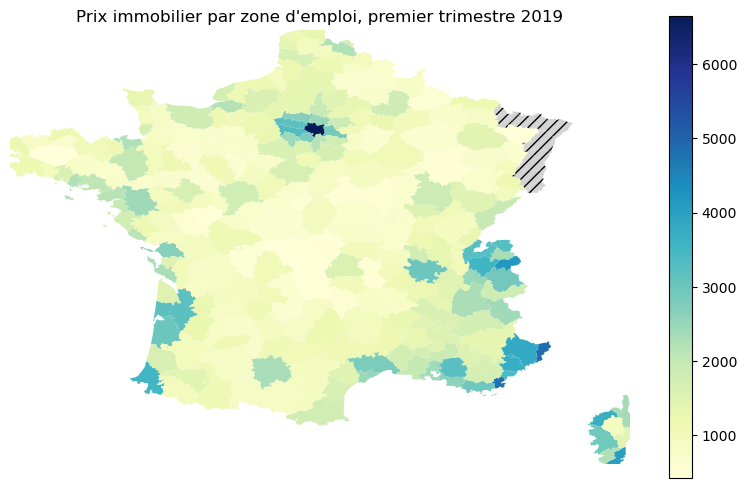

In [8]:
plot_map(full_map[(full_map['Date'] == '20190101')|(full_map['Date'].isna())], 
         'prixM2', "Prix immobilier par zone d'emploi, premier trimestre 2019", 
         "YlGnBu")

On observe une très forte hétérogénéité des prix de l'immobillier en France. Les prix sont très élevées dans la zone d'emploi de Paris et plus largement dans l'Ouest de l'Ile-de-France, ainsi que dans la Côte d'Azur. On remarque également des prix élevés dans les zones d'emploi proches de la frontière Suisse. Cela est probablement dû à la présence de travailleurs frontaliers. 

Au contraire, les prix immobilier sont faibles dans les zones rurales, en particulier dans le centre de la France.

On note l'absence de données pour une partie de l'Alsace et la Lorraine.


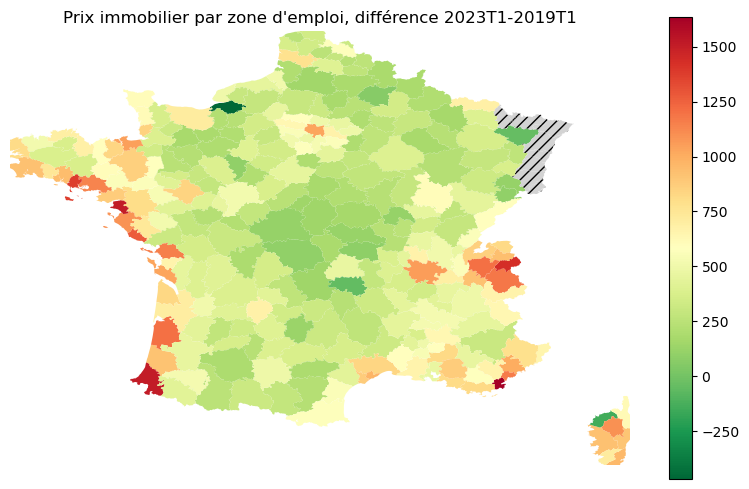

In [9]:
plot_map(full_map[(full_map['Date'] == '20230101')|(full_map['Date'].isna())], 
         'dprix', "Prix immobilier par zone d'emploi, différence 2023T1-2019T1", 
         "RdYlGn_r")

Les prix de l'immobilier sont stables dans l'essentiel de la France. Cependant, certains territoires ont vu de fortes augmentations. Toutes les zones d'emplois situées sur la côte atlantique ont subi des augmentations importantes tout comme celles sur la côte de la méditerannées de la région PACA. On remarque aussi une forte augmentation dans les zones d'emplois proches de la frontière Suisse. Etonnamment, l'augmentation dans la zone d'emploi de Paris entre 2019 et 2023 n'est pas la plus élevée, elle s'élève à environ 1000 euros du mètre carré contre environ 1500 euros pour la zone d'emploi de Sainte Maxime. 

On note de même l'absence de données pour une partie de l'Alsace et la Lorraine.

In [10]:
# Plotting time series
def plot_time_series(data, x, y, title, hue=None):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x=x, y=y, hue=hue)
    plt.title(title)
    plt.show()

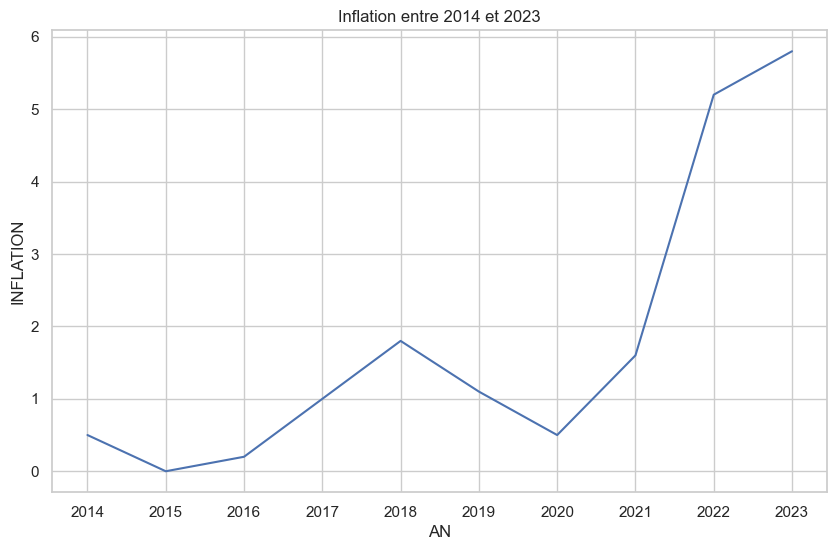

In [11]:
plot_time_series(inflation, "AN", "INFLATION", "Inflation entre 2014 et 2023")

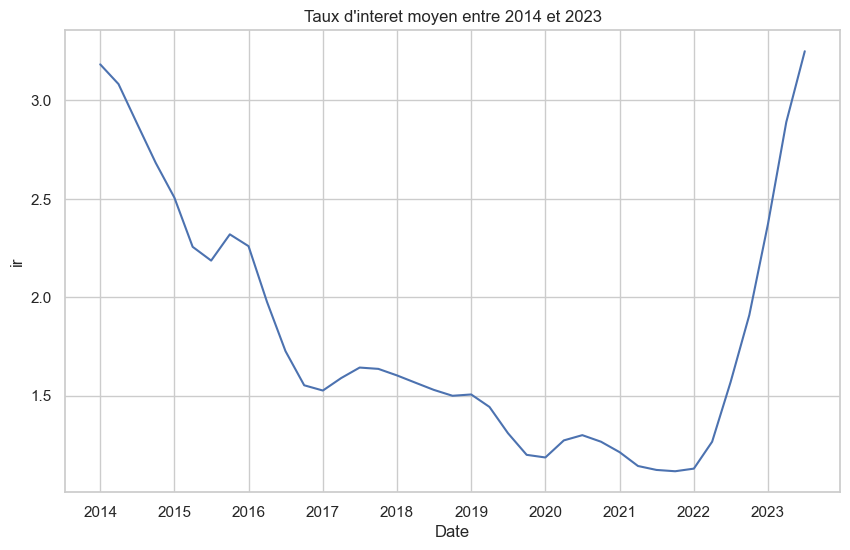

In [12]:
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'], format='%Y%m%d')
plot_time_series(interest_rates, "Date", "ir", "Taux d'interet moyen entre 2014 et 2023")

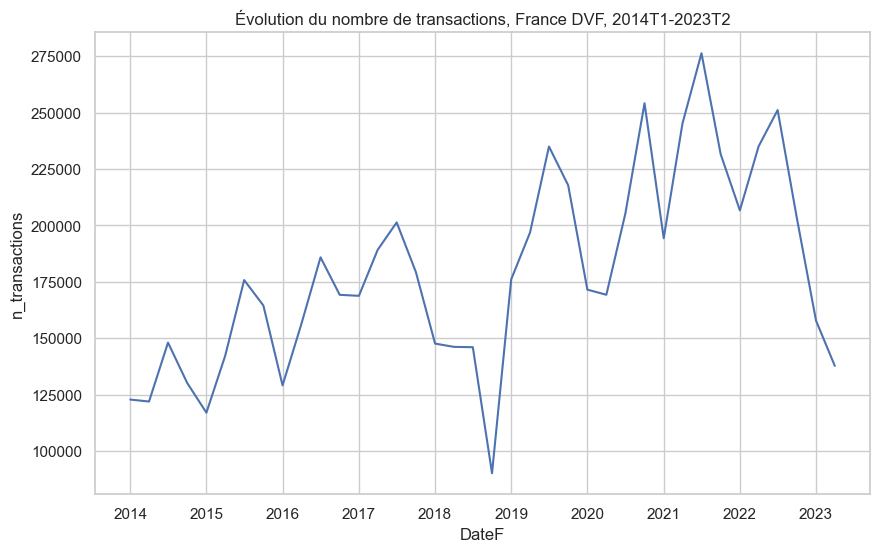

In [13]:
immo_panel_com['DateF'] = pd.to_datetime(immo_panel_com['Date'], format='%Y%m%d')
immo_panel_com_grouped = immo_panel_com.groupby('DateF').agg({'n_transactions': 'sum'}).reset_index()
plot_time_series(immo_panel_com_grouped, 'DateF', 'n_transactions', 
                 "Évolution du nombre de transactions, France DVF, 2014T1-2023T2")

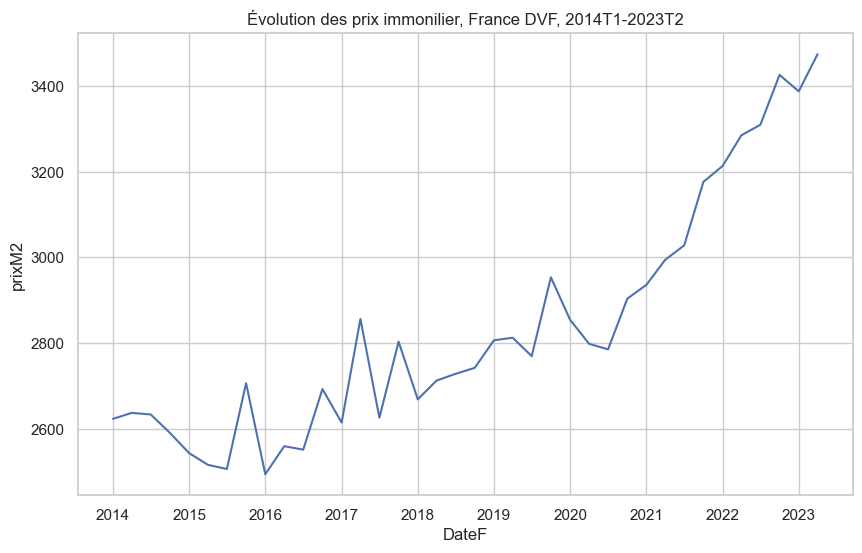

In [14]:
immo_panel_full['DateF'] = pd.to_datetime(immo_panel_full['Date'], format='%Y%m%d')
plot_time_series(immo_panel_full, 'DateF', 'prixM2', 
                 "Évolution des prix immonilier, France DVF, 2014T1-2023T2")

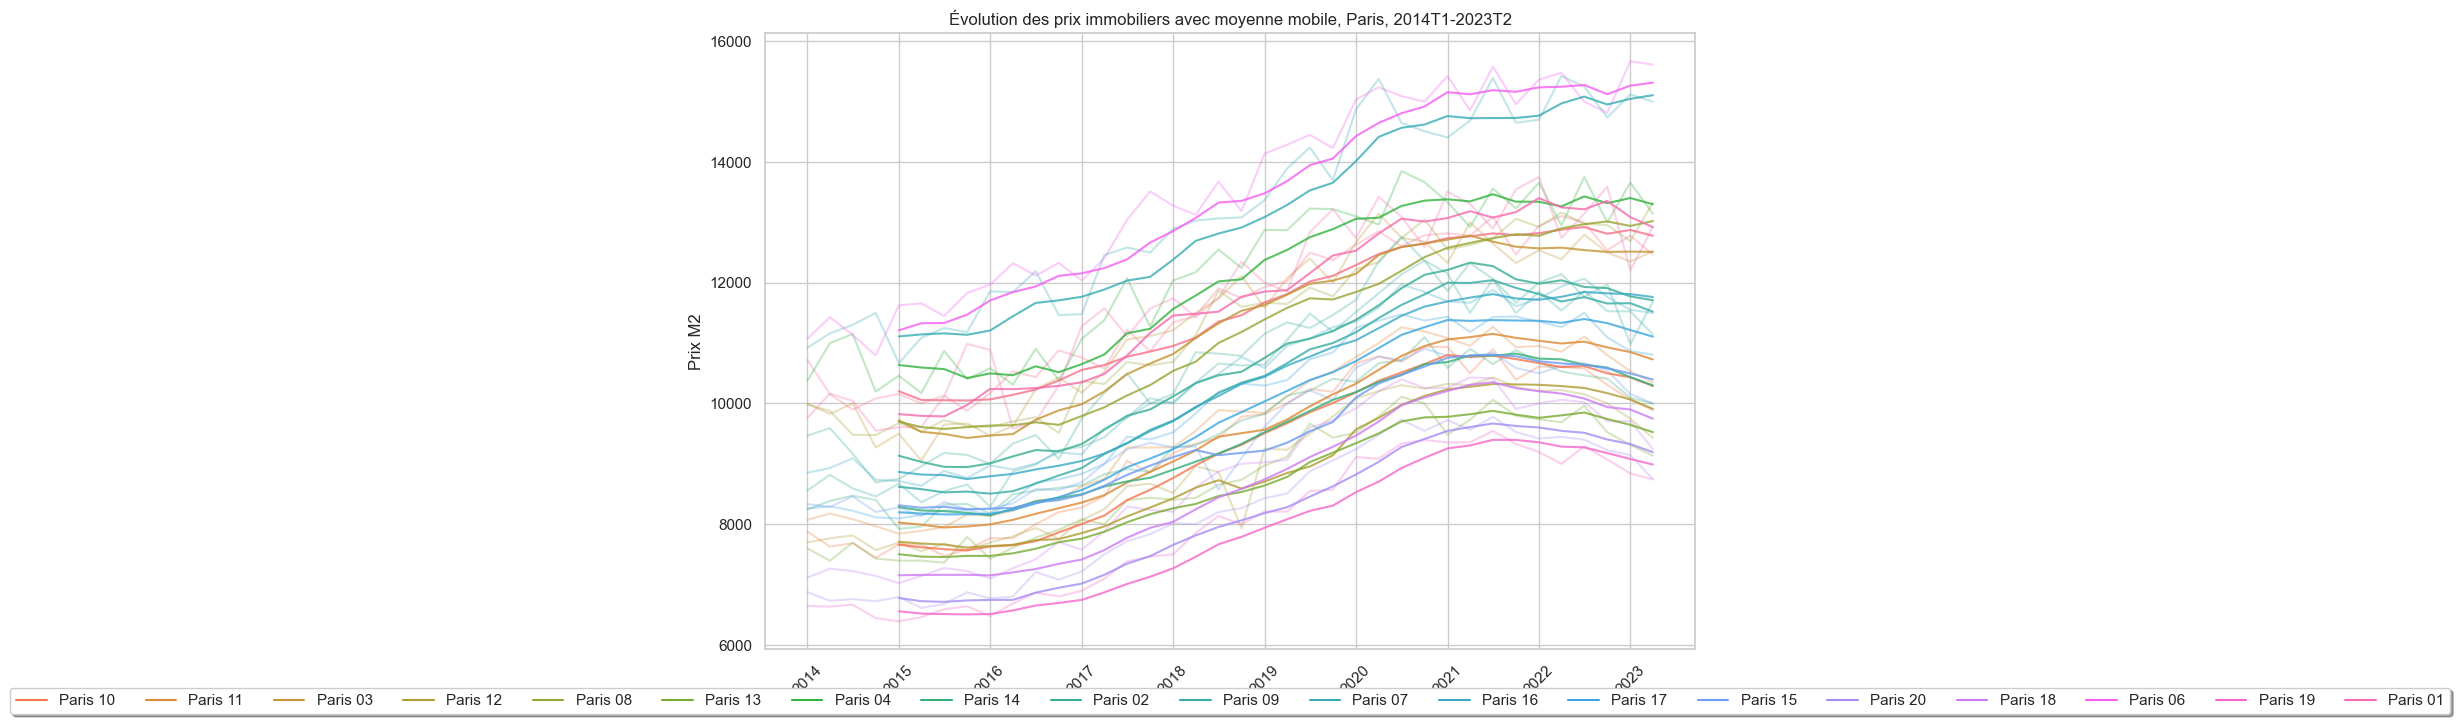

In [15]:
# Evolution des prix parisiens ---
paris_data = immo_panel_com[immo_panel_com['LIB_COM'].str.startswith('Paris ')]
paris_data = paris_data.sort_values(by='DateF')
window_size = 5  
paris_data['Moving_Average'] = paris_data.groupby('LIB_COM')['prixM2'].transform(lambda x: x.rolling(window=window_size).mean())
plt.figure(figsize=(12, 8))
sns.lineplot(data=paris_data, x='DateF', y='prixM2', hue='LIB_COM', alpha=0.3)
sns.lineplot(data=paris_data, x='DateF', y='Moving_Average', hue='LIB_COM', alpha=0.8, legend=None)
plt.title('Évolution des prix immobiliers avec moyenne mobile, Paris, 2014T1-2023T2')
plt.xlabel('Date')
plt.ylabel('Prix M2')
plt.xticks(rotation=45)
sns.set_theme(style="whitegrid")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=len(paris_data['LIB_COM'].unique()))
plt.show()

## IV. Creation des variables de contrôle

### Chômage

In [11]:
#IMPORT UNEMPLOYMENT DATA
#source https://www.insee.fr/fr/statistiques/1893230
t_passage = pd.read_feather(path+"/data/interim/tble_de_passage_py.feather")[["COM","ZE","LIB_COM", "LIB_ZE", "EPCI", "LIB_EPCI"]].drop_duplicates()
unemployement = pd.read_excel(path+"/data/external/unemployment/chomage-zone-t1-2003-t3-2023.xlsx", 
                               sheet_name="txcho_ze", skiprows=5)
unemployement_long = pd.melt(unemployement, id_vars=['ZE2020', 'LIBZE2020', 'REG', 'LIBREG'],
                             var_name='Date', value_name='UNEMP')

In [13]:
def transform_date(date):
    if date.endswith('-T1'):
        return date[:4] + '0101'
    elif date.endswith('-T2'):
        return date[:4] + '0401'
    elif date.endswith('-T3'):
        return date[:4] + '0701'
    elif date.endswith('-T4'):
        return date[:4] + '1001'
    else:
        return pd.NA

In [14]:
unemployement_long['Date'] = unemployement_long['Date'].apply(transform_date)
unemployement_long = unemployement_long[pd.to_numeric(unemployement_long['Date'], errors='coerce') > 20131231]

In [15]:
unemployement_long.head()

,ZE2020,LIBZE2020,REG,LIBREG,Date,UNEMP
13288,51,Alençon,0,INTERRÉGIONAL,20140101,9.4
13289,52,Arles,0,INTERRÉGIONAL,20140101,13.4
13290,53,Avignon,0,INTERRÉGIONAL,20140101,12.3
13291,54,Beauvais,0,INTERRÉGIONAL,20140101,10.1
13292,55,Bollène-Pierrelatte,0,INTERRÉGIONAL,20140101,12.8


### Revenus

In [16]:
#IMPORT AVAILABLE INCOME DATA  
#source https://www.insee.fr/fr/statistiques/3126151
#source https://www.insee.fr/fr/statistiques/6036907

income2014 = pd.read_excel(path+"/data/external/revenus/indic-struct-distrib-revenu-2014-COMMUNES/indic-struct-distrib-revenu-2014-COMMUNES/FILO_DISP_COM.xls", 
                               sheet_name="ENSEMBLE", skiprows=5)
income2014 = income2014[["CODGEO","Q214"]]

income2019 = pd.read_excel(path+"/data/external/revenus/indic-struct-distrib-revenu-2019-COMMUNES/FILO2019_DISP_COM.xlsx", 
                               sheet_name="ENSEMBLE", skiprows=5)
income2019 = income2019[["CODGEO","Q219", "GI19"]]

In [17]:
#MERGE 
income2014_2019 = pd.merge(income2014, income2019, how='inner', on = ["CODGEO"])

In [18]:
#ADD column Mediane_evol_diff to observe the evolution of available income between 2019 and 2019
income2014_2019["med_change"] = income2014_2019["Q219"]/income2014_2019["Q214"]
income2014_2019["CODGEO"] = income2014_2019["CODGEO"].astype(str) #preventive bug correction

In [19]:
income2014_2019.head()

,CODGEO,Q214,Q219,GI19,med_change
0,01001,21576.666667,23970,NaN,1.110922
1,01002,21672.857143,23640,NaN,1.090765
2,01004,19756.111111,20510,0.290,1.038160
3,01005,23204.800000,24050,NaN,1.036423
4,01007,21679.333333,23380,0.206,1.078446


### Densité de population

In [8]:
#IMPORT POPULATION AND SURFACE
#https://www.insee.fr/fr/statistiques/7632565
population = pd.read_excel(path+"/data/external/pop_density/base-cc-serie-historique-2020.xlsx", 
                               sheet_name="COM_2020", skiprows=5)[["CODGEO","P20_POP","P14_POP", "SUPERF"]]
population = population[~population['CODGEO'].isin(["75056", "69123", "13055"])]  #Remove Paris, Lyon, Marseille                             
                               
population_arr = pd.read_excel(path+"/data/external/pop_density/base-cc-serie-historique-2020.xlsx", 
                               sheet_name="ARM_2020", skiprows=5)[["CODGEO","P20_POP","P14_POP", "SUPERF"]]

population_arr.loc[population_arr['CODGEO'] == "75112", 'SUPERF'] = 6.37 #correct for Bois de Vincennes
population_arr.loc[population_arr['CODGEO'] == "75116", 'SUPERF'] = 7.91 #correct for Bois de Boulogne


In [9]:
densite = pd.concat([population, population_arr], axis=0, ignore_index=True)
#create popdensity2014 and popdensity2020 : population/surface
densite["popdensity2014"] = densite["P14_POP"] / densite["SUPERF"]
densite["popdensity2020"] = densite["P20_POP"] / densite["SUPERF"]
densite["CODGEO"] = densite["CODGEO"].astype(str) #preventive bug correction

In [20]:
densite.head()

,CODGEO,P20_POP,P14_POP,SUPERF,popdensity2014,popdensity2020
0,01001,806,767,15.95,48.087774,50.532915
1,01002,262,239,9.15,26.120219,28.633880
2,01004,14288,14022,24.60,570.000000,580.813008
3,01005,1782,1627,15.92,102.198492,111.934673
4,01006,113,109,5.88,18.537415,19.217687


In [21]:
#MERGE INCOME2014_2019 AND DENSITE
control_var = pd.merge(income2014_2019,densite,how="inner",on=["CODGEO"])

### Accessibilité aux médecins généralistes

In [36]:
#IMPORT PHYSICISTS accessibility
#source https://data.drees.solidarites-sante.gouv.fr/explore/dataset/530_l-accessibilite-potentielle-localisee-apl/information/
physicist = pd.read_excel(path+"/data/external/physicist/Indicateur d'accessibilité potentielle localisée (APL) aux médecins généralistes.xlsx",sheet_name="APL_2019", skiprows=8)
physicist = physicist[["Code commune INSEE","APL aux médecins généralistes de moins de 65 ans"]]
#renaming variables 
physicist = physicist.rename(columns ={"Code commune INSEE": "CODGEO", "APL aux médecins généralistes de moins de 65 ans" : "Physicist_access"})
physicist = physicist.dropna()


In [37]:
physicist.head()

,CODGEO,Physicist_access
1,01001,2.289
2,01002,2.802
3,01004,4.469
4,01005,4.137
5,01006,0.775


In [38]:
#MERGE
control_var = pd.merge(control_var,physicist,how="inner",on="CODGEO")

### Taux de criminalité

In [39]:
#IMPORT CRIMINALITY
#source (not compressed version) https://www.data.gouv.fr/fr/datasets/bases-statistiques-communale-et-departementale-de-la-delinquance-enregistree-par-la-police-et-la-gendarmerie-nationales/#/resources
criminality = pd.read_csv(path+"/data/external/criminality/donnee-data.gouv-2022-geographie2023-produit-le2023-07-17.csv",sep=",")
criminality = criminality.rename(columns = {"CODGEO_2023":"CODGEO"})
criminality['tauxpourmille'] = criminality['tauxpourmille'].fillna(criminality['complementinfotaux'])
criminality19 = criminality[criminality["annee"].isin([19])]
criminality19['tauxpourmille'] = criminality19['tauxpourmille'].str.replace(",", ".").astype(float)

C:\Users\lujul\AppData\Local\Temp\ipykernel_18728\413589487.py:3: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  criminality = pd.read_csv(path+"/data/external/criminality/donnee-data.gouv-2022-geographie2023-produit-le2023-07-17.csv",sep=",")


In [42]:
burglary19 = criminality19[criminality19["classe"].isin(["Cambriolages de logement"])] #around 70% of Nan in the column tauxpourmille
burglary19 = burglary19[["CODGEO","tauxpourmille"]]
burglary19 = burglary19.rename(columns = {"tauxpourmille":"burglary_for_1000"})

In [49]:
burglary19.head()

,CODGEO,burglary_for_1000
24043,01001,7.926047
24044,01002,7.926047
24045,01004,10.197461
24046,01005,14.944643
24047,01006,7.926047


In [46]:
assault19 = criminality19[criminality19["classe"].isin(["Coups et blessures volontaires"])] #around 60% of Nan in the column faits (number of occurence)
assault19= assault19[["CODGEO","tauxpourmille"]]
assault19 = assault19.rename(columns = {"tauxpourmille":"assault_for_1000"})

In [51]:
assault19.head()

,CODGEO,assault_for_1000
56283,01001,1.738796
56284,01004,7.499646
56285,01005,1.738796
56286,01006,1.738796
56287,01007,1.738796


In [45]:
otherassault19 = criminality19[criminality19["classe"].isin(["Autres coups et blessures volontaires"])] #around 45% of Nan in the column faits (number of occurence)
otherassault19= otherassault19[["CODGEO","tauxpourmille"]]
otherassault19 = otherassault19.rename(columns = {"tauxpourmille":"other_assault_for_1000"})

In [50]:
otherassault19.head()

,CODGEO,other_assault_for_1000
0,01001,0.000000
1,01004,4.386586
2,01005,0.987374
3,01006,0.987374
4,01007,0.987374


In [47]:
destruction19 = criminality19[criminality19["classe"].isin(["Destructions et dégradations volontaires"])] #around 70% of Nan in the column faits (number of occurence)
destruction19 = destruction19[["CODGEO","tauxpourmille"]]
destruction19 = destruction19.rename(columns = {"tauxpourmille":"destruction_for_1000"})

In [52]:
destruction19.head()

,CODGEO,destruction_for_1000
87006,01001,3.704983
87007,01002,3.704983
87008,01004,9.551436
87009,01005,3.704983
87010,01006,3.704983


In [54]:
#MERGE WITH control_var
control_var = pd.merge(control_var,burglary19,how="left",on="CODGEO")
control_var = pd.merge(control_var,assault19,how="left",on="CODGEO")
control_var = pd.merge(control_var,otherassault19,how="left",on="CODGEO")
control_var = pd.merge(control_var,destruction19,how="left",on="CODGEO")

In [56]:
#MERGE WITH TABLE DE PASSAGE
control_var = pd.merge(t_passage,control_var,how="right",right_on="CODGEO", left_on="COM")

In [57]:
control_var.head()

,COM,ZE,LIB_COM,LIB_ZE,EPCI,LIB_EPCI,CODGEO,Q214,Q219,GI19,...,P20_POP,P14_POP,SUPERF,popdensity2014,popdensity2020,Physicist_access,burglary_for_1000,assault_for_1000,other_assault_for_1000,destruction_for_1000
0,01001,8405.0,L'Abergement-Clémenciat,Bourg en Bresse,8405,CC de la Dombes,01001,21576.666667,23970,NaN,...,806,767,15.95,48.087774,50.532915,2.289,7.926047,1.738796,0.000000,3.704983
1,01002,8405.0,L'Abergement-de-Varey,Bourg en Bresse,8405,CC de la Plaine de l'Ain,01002,21672.857143,23640,NaN,...,262,239,9.15,26.120219,28.633880,2.802,7.926047,0.000000,0.000000,3.704983
2,01004,8405.0,Ambérieu-en-Bugey,Bourg en Bresse,8405,CC de la Plaine de l'Ain,01004,19756.111111,20510,0.290,...,14288,14022,24.60,570.000000,580.813008,4.469,10.197461,7.499646,4.386586,9.551436
3,01005,8434.0,Ambérieux-en-Dombes,Villefranche-sur-Saône,8434,CC Dombes Saône Vallée,01005,23204.800000,24050,NaN,...,1782,1627,15.92,102.198492,111.934673,4.137,14.944643,1.738796,0.987374,3.704983
4,01007,8405.0,Ambronay,Bourg en Bresse,8405,CC de la Plaine de l'Ain,01007,21679.333333,23380,0.206,...,2827,2570,33.55,76.602086,84.262295,4.714,15.860428,1.738796,0.987374,6.785714


**Définition des variables** 

| Variable | Description  |  Source | 
|---|---|---|
| Q214   | Revenu disponible médian par unité de consommation en 2014 (€)  | INSEE  | 
| Q219   | Revenu disponible médian par unité de consommation en 2014 (€) | INSEE  | 
| GI19   | Indice de Gini en 2019  | INSEE  | 
| popdensity2014   | Densité de population en 2014 (nombre d'habitants/surface)   | INSEE  | 
| popdensity2020   | Densité de population en 2020 (nombre d'habitants/surface)  | INSEE  | 
| Physicist_access   | Indicateur d'ccessibilité potentielle localisée (APL) aux médecins généralistes* | Ministère de la santé  | 
| burglary_for_1000   | Nombre de cambriolages pour 1000 habitants en 2019  | Ministère de l'intérieur  | 
| assault_for_1000   | Nombre de coups et blessures volontaires pour 1000 habitants en 2019  | Ministère de l'intérieur  | 
| other_assault_for_1000   | Nombre d'autres coups et blessures volontaires pour 1000 habitants en 2019   | Ministère de l'intérieur  | 
| destruction_for_1000  | Nombre de destructions et dégradations volontaires pour 1000 habitants en 2019   | Ministère de l'intérieur  | 

*DREES: "L’indicateur d’accessibilité potentielle localisée (APL) a été développé pour mesurer l’adéquation spatiale entre l’offre et la demande de soins de premier recours à un échelon géographique fin. C'est un indicateur local, disponible au niveau de chaque commune, qui tient compte de l’offre et de la demande issues des communes environnantes. Calculé à l’échelle communale, l’APL met en évidence des disparités d’offre de soins qu’un indicateur usuel de densité, calculé sur des mailles beaucoup plus larges aurait tendance à masquer. Il tient également compte du niveau d’activité des professionnels en exercice ainsi que de la structure par âge de la population de chaque commune qui influence les besoins de soins."

In [ ]:
# Writing output
feather.write_feather(control_var, path+"/data/interim/TI_controls.feather")
feather.write_feather(unemployement_long, path+"/data/interim/TV_controls.feather")

## V. Modélisation économétrique

Dans cette section consacrée à la modélisation, nous ferons appel à des méthodes économétriques afin de tenter de répondre à la problématique centrale de ce projet : dans quelle mesure la hausse récente des taux d'intérêt impacte-t-elle différemment les marchés immobiliers locaux en fonction des caractéristiques de chaque ville ?

Comme mentionné dans les sections précédentes, la disponibilité des variables d'intérêt sous une forme évolutive dans le temps est limitée, ce qui contraint l'usage de méthodes de séries temporelles en panel telles que les PVAR. Par conséquent, nous privilégions des méthodes classiques d'économétrie de panel, telles que les modèles à effets fixes.

Le modèle principal de cette analyse est un modèle à effets fixes. Il intègre comme variables d'intérêt le retard (lag) du taux d'intérêt en interaction avec différentes caractéristiques locales, tout en contrôlant les effets annuels et la structure des transactions effectuées. Des modèles supplémentaires à différents niveaux géographiques sont estimés pour tester la robustesse de nos résultats.

In [61]:
# Custom Functions
def merge_and_transform(base_df, irflation_df, control_df, base_col, min_transactions=30, required_count=38):
    base_df=base_df.drop(columns=["LIB_"+base_col])
    df = base_df[base_df['n_transactions'] > min_transactions]
    df['n'] = df.groupby(base_col)[base_col].transform('count')
    df = df[df['n'] == required_count].drop(columns='n')
    df = df.merge(irflation_df, on='Date', how='left')
    df = df.merge(control_df, on=base_col, how='left')
    df['prixM2'] = df['prixM2'] / df['BASE14']
    df['Q219'] = df['Q219'] / irflation['BASE14'][20]
    df['med_change'] = (df['Q219'] / irflation_df['BASE14'][20]) - (df['Q214'] / irflation_df['BASE14'][0])
    df['dens_change'] = df['popdensity2019'] - df['popdensity2014']
    return df

In [62]:
def group_and_calculate_diff(df, group_cols):
    df = df.sort_values(by=group_cols + ['Date'])
    grouped = df.groupby(group_cols)
    df['diff_prixM2'] = grouped['prixM2'].diff().fillna(np.nan)
    df['diff2_prixM2'] = grouped['prixM2'].diff().diff().fillna(np.nan)
    df['prixM2_FE'] = grouped['prixM2'].transform(lambda x: x - x.mean()) #Within transformation
    df['year'] = df['Date'].str[:4]
    df['diff2_prop_maison'] = grouped['prop_maison'].diff().fillna(np.nan)
    df['diff_ir'] = grouped['ir'].diff().fillna(np.nan)
    df['lag_ir'] = grouped['ir'].shift(1)
    df['lag2_ir'] = grouped['ir'].shift(2)
    df['lag4_ir'] = grouped['ir'].shift(4)
    df['diff_lag_ir'] = grouped['lag_ir'].diff().fillna(np.nan)
    df['diff2_lag_ir'] = grouped['lag_ir'].diff().diff().fillna(np.nan)
    return df.reset_index(drop=True)

In [63]:
def run_regression(df, formula):
    model = smf.ols(formula, data=df)
    results = model.fit()
    return(results)

In [64]:
def aggregate_data(df, group_cols, agg_dict):
    agg_df = df.groupby(group_cols).agg(agg_dict).reset_index()
    agg_df['popdensity2019'] = agg_df['P20_POP'] / agg_df['SUPERF']
    agg_df['popdensity2014'] = agg_df['P14_POP'] / agg_df['SUPERF']
    return agg_df.drop(columns=['P20_POP', 'P14_POP', 'SUPERF'])

In [65]:
def corplot(df, nom):
  plt.figure(figsize=(10, 8))
  sns.heatmap(df, annot=True, cmap='coolwarm')
  plt.title('Correlations intra-ville pour '+nom)
  plt.show()

In [66]:
def cor_ville(df, nom):
  df = df[df['LIB_COM']==nom]
  df = df[["prixM2", "ir","lag_ir","lag2_ir","lag4_ir", "prop_maison"]].dropna().corr()
  return(df)

In [73]:
# Reading Data
base_path = path + "/data/interim/"
immo_epci = pd.read_feather(base_path + "immo_panel_epci_py.feather")
immo_ze = pd.read_feather(base_path + "immo_panel_ze_py.feather")
immo_com = pd.read_feather(base_path + "immo_panel_com_py.feather")
immo_full = pd.read_feather(base_path + "immo_panel_full_py.feather")
unemployment = pd.read_feather(base_path + "TV_controls.feather")
control = pd.read_feather(base_path + "TI_controls.feather")
irflation = pd.read_feather(base_path + "irflation.feather")

In [74]:
# Aggregate data
agg_dict_control = {
    'Q219': 'mean', 'Q214': 'mean',
    'P20_POP': 'sum', 'P14_POP': 'sum',
    'SUPERF': 'sum', 'Physicist_access': 'mean',
    'assault_for_1000': 'mean'
}
control_ze = aggregate_data(control, ['ZE', 'LIB_ZE'], agg_dict_control)
control_epci = aggregate_data(control, ['EPCI', 'LIB_EPCI'], agg_dict_control)

In [75]:
control_ze

,ZE,LIB_ZE,Q219,Q214,Physicist_access,assault_for_1000,popdensity2019,popdensity2014
0,51.0,Alençon,20997.962963,19513.189514,2.082500,1.755776,55.113269,56.711867
1,52.0,Arles,21809.000000,19972.087654,3.420800,3.236450,72.920998,73.127843
2,53.0,Avignon,22300.000000,20545.182303,3.394056,2.740536,417.644716,410.739621
3,54.0,Beauvais,22776.977492,21354.075800,2.484302,2.126033,101.060545,99.605781
4,55.0,Bollène-Pierrelatte,22470.000000,20853.342050,2.636862,2.360175,116.635591,114.159934
...,...,...,...,...,...,...,...,...
292,9403.0,Calvi,20157.692308,17556.055940,2.501885,2.770986,30.841287,29.282792
293,9404.0,Corte,19877.619048,18417.861064,2.302619,2.429574,17.854459,17.851954
294,9405.0,Ghisonaccia,19199.500000,17423.182708,1.318500,2.395572,21.200251,20.658202
295,9406.0,Porto-Vecchio,20430.000000,18183.271573,3.065545,3.696087,29.525449,28.948056


In [69]:
# Processing for immo_reg_com
immo_reg_com = merge_and_transform(immo_com, irflation, control, 'COM')
immo_reg_com_diff = group_and_calculate_diff(immo_reg_com, ['COM'])

C:\Users\lujul\AppData\Local\Temp\ipykernel_18728\2077282402.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n'] = df.groupby(base_col)[base_col].transform('count')


In [70]:
# Processing for immo_reg_ze
immo_reg_ze = merge_and_transform(immo_ze, irflation, control_ze, 'ZE')
immo_reg_ze_diff = group_and_calculate_diff(immo_reg_ze, ['ZE', 'LIB_ZE'])
immo_reg_ze_diff = immo_reg_ze_diff.merge(unemployment[['ZE2020', 'Date', 'UNEMP']], left_on=['ZE', 'Date'], right_on=['ZE2020', 'Date'], how='left')
immo_reg_ze_diff['lag_UNEMP'] = immo_reg_ze_diff.groupby(['ZE', 'LIB_ZE'])['UNEMP'].shift(1)
immo_reg_ze_diff['diff2_lag_unemp'] = immo_reg_ze_diff.groupby(['ZE', 'LIB_ZE'])['UNEMP'].shift().diff().diff()

C:\Users\lujul\AppData\Local\Temp\ipykernel_18728\2077282402.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n'] = df.groupby(base_col)[base_col].transform('count')


In [71]:
# Processing for immo_reg_epci
immo_reg_epci = merge_and_transform(immo_epci, irflation, control_epci, 'EPCI')
immo_reg_epci_diff = group_and_calculate_diff(immo_reg_epci, ['EPCI', 'LIB_EPCI'])

C:\Users\lujul\AppData\Local\Temp\ipykernel_18728\2077282402.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n'] = df.groupby(base_col)[base_col].transform('count')


### Test de Granger

Le marché immobilier, étant moins liquide que les marchés financiers, ne révèle l'impact du taux d'intérêt sur les prix qu'après un certain délai. Il est courant dans la littérature de considérer le retard du taux d'intérêt plutôt que le taux lui-même, comme illustré par Harris (1989) dans _The Effect of Real Rates of Interest on Housing Prices_. Cependant, cette transmission varie selon les caractéristiques des marchés immobiliers et le contexte macroéconomique. Ainsi, pour déterminer le nombre approprié de retards du taux d'intérêt dans l'analyse des marchés locaux en France, nous employons un test de Granger. Ce test évalue si une série temporelle améliore la prédiction d'une autre série temporelle et, par conséquent, si elle est pertinente pour son analyse. $$\Delta ({p}/m^{2})_t \sim \Delta L^n(i_t)$$ Nous cherchons à déterminer si l'utilisation du taux d'intérêt avec plusieurs retards apporte des informations sur les prix immobiliers. L'hypothèse nulle est l'absence de pouvoir prédictif. Pour obtenir des séries stationnaires, nous utilisons la différence. Bien qu'il existe des méthodes pour généraliser le test de Granger à des données en panel (Holtz-Eakin et al., 1988), celles-ci n'ont pas été développées en Python. Pour obtenir une idée générale du nombre de retards requis, nous appliquons le test à quelques villes de tailles variées choisies aléatoirement.

In [77]:
# Granger Causality Test
for i in ["Paris 14","Clermont-Ferrand","Le Grau-du-Roi", "Cagnes-sur-Mer", "Savigny-sur-Orge"]:
  print(i)
  granger_test3 = grangercausalitytests(immo_reg_com_diff[immo_reg_com_diff["LIB_COM"]==i][['diff_prixM2', 'diff_ir']].dropna(), maxlag=5, verbose=True)

Paris 14

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7132  , p=0.0372  , df_denom=33, df_num=1
ssr based chi2 test:   chi2=5.1417  , p=0.0234  , df=1
likelihood ratio test: chi2=4.8061  , p=0.0284  , df=1
parameter F test:         F=4.7132  , p=0.0372  , df_denom=33, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9161  , p=0.1648  , df_denom=30, df_num=2
ssr based chi2 test:   chi2=4.4709  , p=0.1069  , df=2
likelihood ratio test: chi2=4.2075  , p=0.1220  , df=2
parameter F test:         F=1.9161  , p=0.1648  , df_denom=30, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8979  , p=0.0533  , df_denom=27, df_num=3
ssr based chi2 test:   chi2=10.9478 , p=0.0120  , df=3
likelihood ratio test: chi2=9.4908  , p=0.0234  , df=3
parameter F test:         F=2.8979  , p=0.0533  , df_denom=27, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7984  , p=0.162

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Il apparaît que, selon la commune, si un effet existe, entre 1 et 3 trimestres sont nécessaires pour que le taux d'intérêt ait un pouvoir explicatif sur les prix immobiliers.

### Corrélations

Afin d'observer les interactions entre les variables d'intérêt choisies et d'obtenir une première impression de ce que la modélisation peut apporter, il est utile de construire des matrices de corrélations. D'abord, une matrice pour l'ensemble du panel, puis pour les trois premières villes utilisées lors du test de Granger.

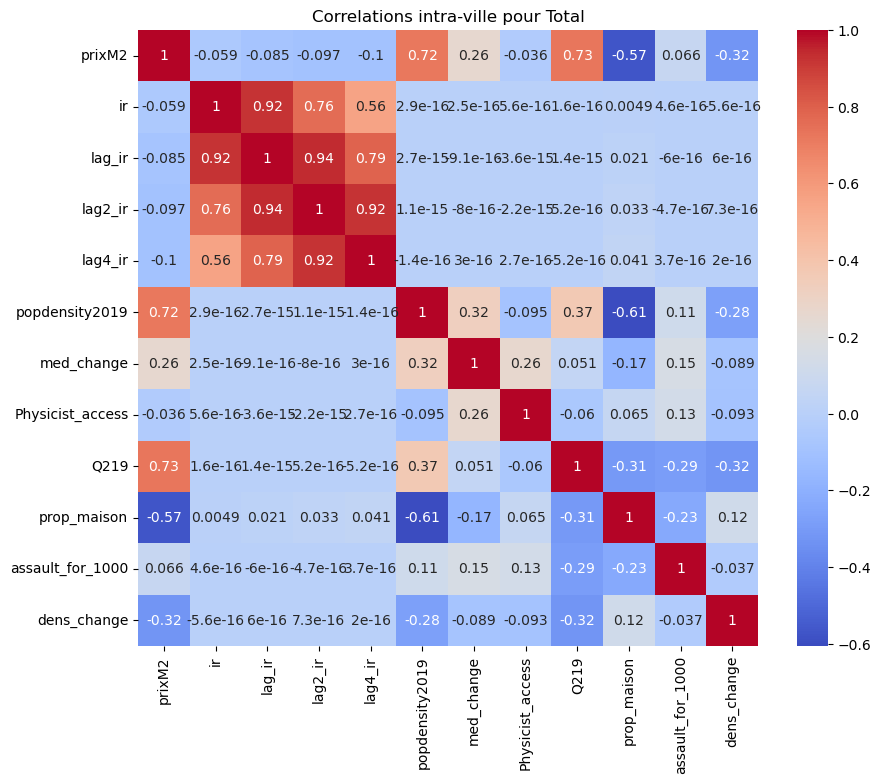

In [78]:
# Total 
immo_reg_corr =immo_reg_com_diff[["prixM2", "ir","lag_ir","lag2_ir","lag4_ir","popdensity2019", "med_change", "Physicist_access", "Q219", "prop_maison", "assault_for_1000", "dens_change"]].dropna().corr()
corplot(immo_reg_corr, "Total")

Cette matrice révèle une corrélation relativement faible entre les prix et le taux d'intérêt, quel que soit le nombre de retards. En revanche, les corrélations sont significatives entre les prix et la densité en 2020, l'évolution des revenus médians dans la commune, la proportion de maisons dans le total des transactions, et les changements de densité. La faible corrélation entre le taux d'intérêt et les prix s'explique probablement par la dimension NN de notre panel, bien plus importante que la dimension TT, le taux d'intérêt étant identique pour toutes les villes à chaque période.

Pour vérifier cela, il est possible d'établir des matrices de corrélations pour quelques villes, en excluant les variables constantes dans le temps. Par exemple, pour le 14e arrondissement de Paris : 

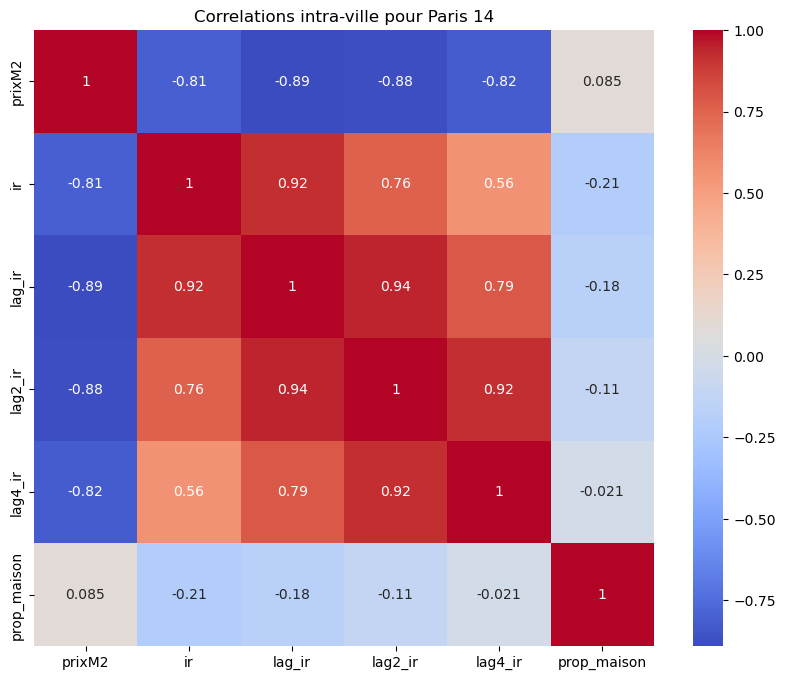

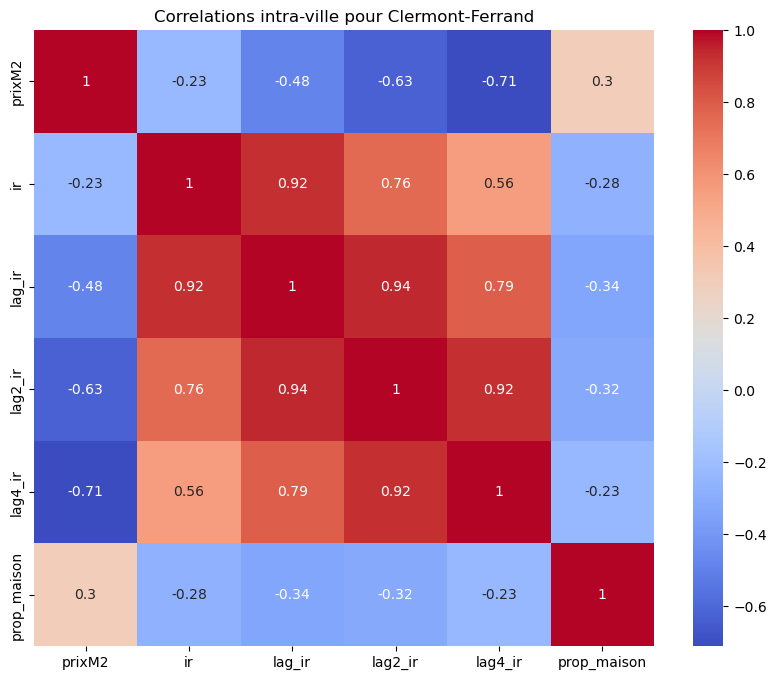

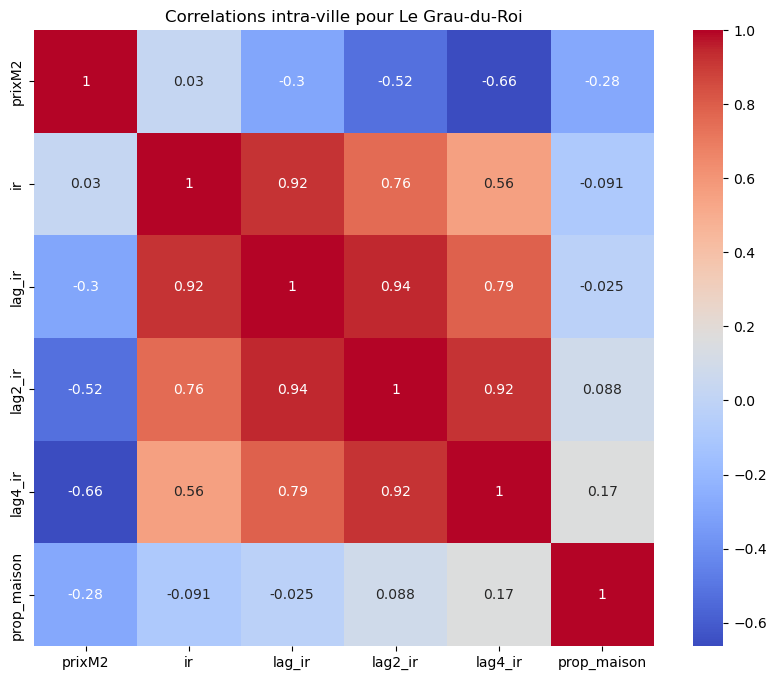

In [79]:
# Intra villes
for i in ["Paris 14","Clermont-Ferrand","Le Grau-du-Roi"]:
  corplot(cor_ville(immo_reg_com_diff, i), i)

Les corrélations avec le taux d'intérêt sont plus fortes, toujours négatives, et généralement plus élevées dans les deux villes de taille supérieur. De plus, la corrélation est plus forte au premier retard à Paris, tandis que pour Clermont-Ferrand et le Grau-du-Roi, elle est plus importante au troisième retard. Cela pourrait indiquer un effet différencié du taux d'intérêt selon la taille de la ville.


### Modèles communaux

#### Modèle 1a - Modèle simple du taux d'intérêt

#### Modèle 1b - Modèle complet avec effets fixes

#### Modèle 1c - Modèle logarithmique sans effets fixes

#### Modèle 2 - Modèle avec prix dé-tendanciés

### Modèles ZE (Zone d'Emploi)

#### Modèle 3 - Spécification ZE du modèle complet

### Modèles EPCI (Établissement Public de Coopération Intercommunale)

#### Modèle 4 - Spécification EPCI du modèle complet